## 1. Import Libraries

In [62]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)


from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
RareLabelEncoder,
MeanEncoder,
CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2 . Display Settings

In [63]:
pd.set_option("display.max_columns",None)

In [64]:
sklearn.set_config(transform_output="pandas")

In [65]:
warnings.filterwarnings("ignore")

## Read Data

In [66]:
path = r"train.csv"
train = pd.read_csv(path)

In [67]:

train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [69]:
x_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation operations

### 4.1 airline

In [70]:
x_train.airline

0            Jet Airways
1              Air India
2              Air India
3                Vistara
4                Vistara
             ...        
635             Air Asia
636          Jet Airways
637               Indigo
638    Multiple Carriers
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [71]:
air_transformer = Pipeline(steps=[("Imputer",SimpleImputer(strategy="most_frequent")),
                                 ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2))
                                 ,("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
                                 ])

air_transformer.fit_transform(x_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,0.0,1.0,0.0


### 4.2 date_of_journey 

In [72]:
x_train.date_of_journey

0      2019-06-21
1      2019-05-18
2      2019-06-12
3      2019-04-01
4      2019-06-06
          ...    
635    2019-04-12
636    2019-05-09
637    2019-05-15
638    2019-05-15
639    2019-05-21
Name: date_of_journey, Length: 640, dtype: object

In [73]:
feature_to_extract = ["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps=[("dt",DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format="mixed"))
                                 ,("scaler",MinMaxScaler())
                                 ])
doj_transformer.fit_transform(x_train.loc[:,["date_of_journey"]])



,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.941176,0.666667,0.949153
1,0.666667,0.647059,0.833333,0.661017
2,1.000000,0.882353,0.333333,0.872881
3,0.333333,0.294118,0.000000,0.262712
4,1.000000,0.823529,0.500000,0.822034
...,...,...,...,...
635,0.333333,0.352941,0.666667,0.355932
636,0.666667,0.588235,0.500000,0.584746
637,0.666667,0.647059,0.333333,0.635593
638,0.666667,0.647059,0.333333,0.635593


## 4.3 source and destination

In [74]:
x_train.source

0        Mumbai
1         Delhi
2       Kolkata
3       Kolkata
4       Kolkata
         ...   
635    Banglore
636     Kolkata
637    Banglore
638       Delhi
639     Kolkata
Name: source, Length: 640, dtype: object

In [75]:
x_train.destination

0      Hyderabad
1         Cochin
2       Banglore
3       Banglore
4       Banglore
         ...    
635        Delhi
636     Banglore
637        Delhi
638       Cochin
639     Banglore
Name: destination, Length: 640, dtype: object

In [76]:
location_subset = x_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Banglore,Delhi
636,Kolkata,Banglore
637,Banglore,Delhi
638,Delhi,Cochin


In [77]:
location_pipe_1 = Pipeline(steps=[("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2))
                                  ,("encoder",MeanEncoder()),
                                 ("scaler",PowerTransformer())])
location_pipe_1.fit_transform(location_subset,y_train)


,source,destination
0,-1.855189,-0.904387
1,1.010384,1.009568
2,0.001513,-0.024692
3,0.001513,-0.024692
4,0.001513,-0.024692
...,...,...
635,-1.066757,-1.786597
636,0.001513,-0.024692
637,-1.066757,-1.786597
638,1.010384,1.009568


In [78]:

def is_north(x):
    columns = x.columns.to_list()
    north_cities = ["Delhi","Kolkata","Mumbai","New Delhi"]
    return(x.assign(**{f"{col}_is_north":x.loc[:,col].isin(north_cities).astype(int)
              for col in columns        })
          .drop(columns=columns)
          )


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,0,1
638,1,0


In [79]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe_1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.855189,-0.904387,1,0
1,1.010384,1.009568,1,0
2,0.001513,-0.024692,1,0
3,0.001513,-0.024692,1,0
4,0.001513,-0.024692,1,0
...,...,...,...,...
635,-1.066757,-1.786597,0,1
636,0.001513,-0.024692,1,0
637,-1.066757,-1.786597,0,1
638,1.010384,1.009568,1,0


### 4.4 dep_time and arrival_time

In [80]:
x_train.dep_time

0      10:20:00
1      09:00:00
2      09:10:00
3      20:20:00
4      17:00:00
         ...   
635    04:55:00
636    09:35:00
637    06:05:00
638    08:45:00
639    20:00:00
Name: dep_time, Length: 640, dtype: object

In [81]:
x_train.arrival_time

0      11:50:00
1      07:40:00
2      11:05:00
3      22:55:00
4      10:45:00
         ...   
635    07:45:00
636    21:05:00
637    08:50:00
638    21:00:00
639    12:00:00
Name: arrival_time, Length: 640, dtype: object

In [82]:
time_subset = x_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,10:20:00,11:50:00
1,09:00:00,07:40:00
2,09:10:00,11:05:00
3,20:20:00,22:55:00
4,17:00:00,10:45:00
...,...,...
635,04:55:00,07:45:00
636,09:35:00,21:05:00
637,06:05:00,08:50:00
638,08:45:00,21:00:00


In [83]:
timepipe1 = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())
])

timepipe1.fit_transform(time_subset)


,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.434783,0.363636,0.478261,0.909091
1,0.391304,0.000000,0.304348,0.727273
2,0.391304,0.181818,0.478261,0.090909
3,0.869565,0.363636,0.956522,1.000000
4,0.739130,0.000000,0.434783,0.818182
...,...,...,...,...
635,0.173913,1.000000,0.304348,0.818182
636,0.391304,0.636364,0.913043,0.090909
637,0.260870,0.090909,0.347826,0.909091
638,0.347826,0.818182,0.913043,0.000000


In [84]:
def part_of_day(x,morning=4,noon=12,eve=16,night=20):
    columns = x.columns.to_list()
    x_temp = x.assign(**{col:pd.to_datetime(x.loc[:,col]).dt.hour
                        for col in columns
                        })
    
    return (x_temp.assign(**{
        f"{col}_part_of_day":np.select(
        [x_temp.loc[:,col].between(morning,noon,inclusive="left"),
        x_temp.loc[:,col].between(noon,eve,inclusive="left"),
        x_temp.loc[:,col].between(eve,night,inclusive="left")],
        ["morning","afternoon","evening"],
           default="night" 
        
        )
        for col in columns
    })
           .drop(columns=columns)
           )


FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,morning
2,morning,morning
3,night,night
4,evening,morning
...,...,...
635,morning,morning
636,morning,night
637,morning,morning
638,morning,night


In [85]:
time_pip2 = Pipeline(steps=[("part1",FunctionTransformer(func=part_of_day)),
                           ("encode",CountFrequencyEncoder()),
                            ("scaler" ,MinMaxScaler())
                           ])

time_pip2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.932584
1,1.000000,0.932584
2,1.000000,0.932584
3,0.135747,1.000000
4,0.185520,0.932584
...,...,...
635,1.000000,0.932584
636,1.000000,1.000000
637,1.000000,0.932584
638,1.000000,1.000000


In [86]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1",timepipe1),
    ("part2",time_pip2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.434783,0.363636,0.478261,0.909091,1.000000,0.932584
1,0.391304,0.000000,0.304348,0.727273,1.000000,0.932584
2,0.391304,0.181818,0.478261,0.090909,1.000000,0.932584
3,0.869565,0.363636,0.956522,1.000000,0.135747,1.000000
4,0.739130,0.000000,0.434783,0.818182,0.185520,0.932584
...,...,...,...,...,...,...
635,0.173913,1.000000,0.304348,0.818182,1.000000,0.932584
636,0.391304,0.636364,0.913043,0.090909,1.000000,1.000000
637,0.260870,0.090909,0.347826,0.909091,1.000000,0.932584
638,0.347826,0.818182,0.913043,0.000000,1.000000,1.000000


### 4.5 duration

In [87]:
x_train.duration

0        90
1      1360
2      1555
3      1595
4      1065
       ... 
635     170
636     690
637     165
638     735
639     960
Name: duration, Length: 640, dtype: int64

In [88]:

(
x_train
.duration
.quantile([0.25, 0.5, 0.75])
.values
.reshape(-1, 1))

array([[175.  ],
       [505.  ],
       [956.25]])

In [89]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

TabError: inconsistent use of tabs and spaces in indentation (747963827.py, line 23)

In [90]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(x_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.000000e+00,0.904837,0.904837
1,0.0,0.000000e+00,1.000000,1.000000
2,0.0,0.000000e+00,0.904837,0.904837
3,0.0,0.000000e+00,1.000000,1.000000
4,0.0,5.193201e-57,1.000000,1.000000
...,...,...,...,...
635,0.0,0.000000e+00,0.904837,0.904837
636,0.0,0.000000e+00,1.000000,1.000000
637,0.0,0.000000e+00,0.904837,0.904837
638,0.0,0.000000e+00,1.000000,1.000000


In [91]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [92]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [93]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(x_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364072,-0.132454,-0.099279,0.0,0,-1.100128
1,-0.364072,-0.132454,-0.099279,2.0,1,1.444835
2,-0.364072,-0.132454,-0.099279,2.0,1,1.835597
3,-0.364072,-0.132454,-0.099279,2.0,1,1.915754
4,-0.364072,-0.132454,-0.099279,2.0,1,0.853682
...,...,...,...,...,...,...
635,2.649340,-0.132454,-0.099279,0.0,0,-0.939815
636,-0.364072,-0.132454,-0.099279,2.0,0,0.102217
637,-0.359672,-0.132454,-0.099279,0.0,0,-0.949835
638,-0.364072,-0.132454,-0.099279,2.0,0,0.192393


4.6 total_stops

In [94]:

x_train.total_stops

0      0.0
1      1.0
2      2.0
3      1.0
4      1.0
      ... 
635    0.0
636    1.0
637    0.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [95]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,2.0,0
3,1.0,0
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,0.0,1
638,1.0,0


4.7 additional_info

In [96]:

x_train.additional_info

0      In-flight meal not included
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [97]:

info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [98]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [99]:

info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])


In [100]:

info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5.Column Transformer

In [101]:
column_transformer = ColumnTransformer(transformers=[("air",air_transformer,["airline"]),
                                                     ("doj",doj_transformer,["date_of_journey"])
                                                     ,("location",location_transformer,["source","destination"]),
                                                     ("time",time_transformer,["dep_time","arrival_time"])
                                       ],remainder = "passthrough")

column_transformer.fit_transform(x_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,remainder__duration,remainder__total_stops,remainder__additional_info
0,0.0,0.0,1.0,0.0,0.0,1.000000,0.941176,0.666667,0.949153,-1.855189,-0.904387,1,0,0.434783,0.363636,0.478261,0.909091,1.000000,0.932584,90,0.0,In-flight meal not included
1,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.010384,1.009568,1,0,0.391304,0.000000,0.304348,0.727273,1.000000,0.932584,1360,1.0,No Info
2,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,0.001513,-0.024692,1,0,0.391304,0.181818,0.478261,0.090909,1.000000,0.932584,1555,2.0,No Info
3,0.0,0.0,0.0,0.0,1.0,0.333333,0.294118,0.000000,0.262712,0.001513,-0.024692,1,0,0.869565,0.363636,0.956522,1.000000,0.135747,1.000000,1595,1.0,No Info
4,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.500000,0.822034,0.001513,-0.024692,1,0,0.739130,0.000000,0.434783,0.818182,0.185520,0.932584,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.666667,0.355932,-1.066757,-1.786597,0,1,0.173913,1.000000,0.304348,0.818182,1.000000,0.932584,170,0.0,No Info
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,0.001513,-0.024692,1,0,0.391304,0.636364,0.913043,0.090909,1.000000,1.000000,690,1.0,No Info
637,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-1.066757,-1.786597,0,1,0.260870,0.090909,0.347826,0.909091,1.000000,0.932584,165,0.0,No Info
638,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.333333,0.635593,1.010384,1.009568,1,0,0.347826,0.818182,0.913043,0.000000,1.000000,1.000000,735,1.0,No Info



5. Feature Selection

In [102]:

estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
)


6. Putting it all Together

In [103]:

preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,remainder__duration,remainder__total_stops,remainder__additional_info
0,0.0,1.0,0.0,0.941176,0.949153,-1.855189,-0.904387,90,0.0,In-flight meal not included
1,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,1360,1.0,No Info
2,0.0,0.0,0.0,0.882353,0.872881,0.001513,-0.024692,1555,2.0,No Info
3,0.0,0.0,1.0,0.294118,0.262712,0.001513,-0.024692,1595,1.0,No Info
4,0.0,0.0,1.0,0.823529,0.822034,0.001513,-0.024692,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.352941,0.355932,-1.066757,-1.786597,170,0.0,No Info
636,0.0,1.0,0.0,0.588235,0.584746,0.001513,-0.024692,690,1.0,No Info
637,1.0,0.0,0.0,0.647059,0.635593,-1.066757,-1.786597,165,0.0,No Info
638,0.0,0.0,0.0,0.647059,0.635593,1.010384,1.009568,735,1.0,No Info



7. Visualizations

In [104]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.0004934775676132356,
 'air__airline_Indigo': 0.11143357665144797,
 'air__airline_Jet Airways': 0.14506076487015315,
 'air__airline_Multiple Carriers': -0.003073250116394773,
 'air__airline_Other': 0.10720239661922266,
 'doj__date_of_journey_month': 0.07587871136576778,
 'doj__date_of_journey_week': 0.17309192040384677,
 'doj__date_of_journey_day_of_week': -0.019500664285657814,
 'doj__date_of_journey_day_of_year': 0.20504259758740517,
 'location__source': 0.14743682918716292,
 'location__destination': 0.15866333325687323,
 'location__source_is_north': 0.04359756801151038,
 'location__destination_is_north': 0.04359756801151038,
 'time__dep_time_hour': -0.022199415197866428,
 'time__dep_time_minute': 0.026288954687537263,
 'time__arrival_time_hour': 0.07200269878055865,
 'time__arrival_time_minute': 0.011447444082674988,
 'time__dep_time_part_of_day': -0.008058685914884345,
 'time__arrival_time_part_of_day': 0.014250114500499103,
 'remainder__duration': 0.45

In [105]:

sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': -0.022199415197866428,
 'doj__date_of_journey_day_of_week': -0.019500664285657814,
 'time__dep_time_part_of_day': -0.008058685914884345,
 'air__airline_Multiple Carriers': -0.003073250116394773,
 'air__airline_Air India': -0.0004934775676132356,
 'time__arrival_time_minute': 0.011447444082674988,
 'time__arrival_time_part_of_day': 0.014250114500499103,
 'time__dep_time_minute': 0.026288954687537263,
 'location__source_is_north': 0.04359756801151038,
 'location__destination_is_north': 0.04359756801151038,
 'time__arrival_time_hour': 0.07200269878055865,
 'doj__date_of_journey_month': 0.07587871136576778,
 'air__airline_Other': 0.10720239661922266,
 'air__airline_Indigo': 0.11143357665144797,
 'air__airline_Jet Airways': 0.14506076487015315,
 'location__source': 0.14743682918716292,
 'location__destination': 0.15866333325687323,
 'doj__date_of_journey_week': 0.17309192040384677,
 'doj__date_of_journey_day_of_year': 0.20504259758740517,
 'remainder__total_stops': 0

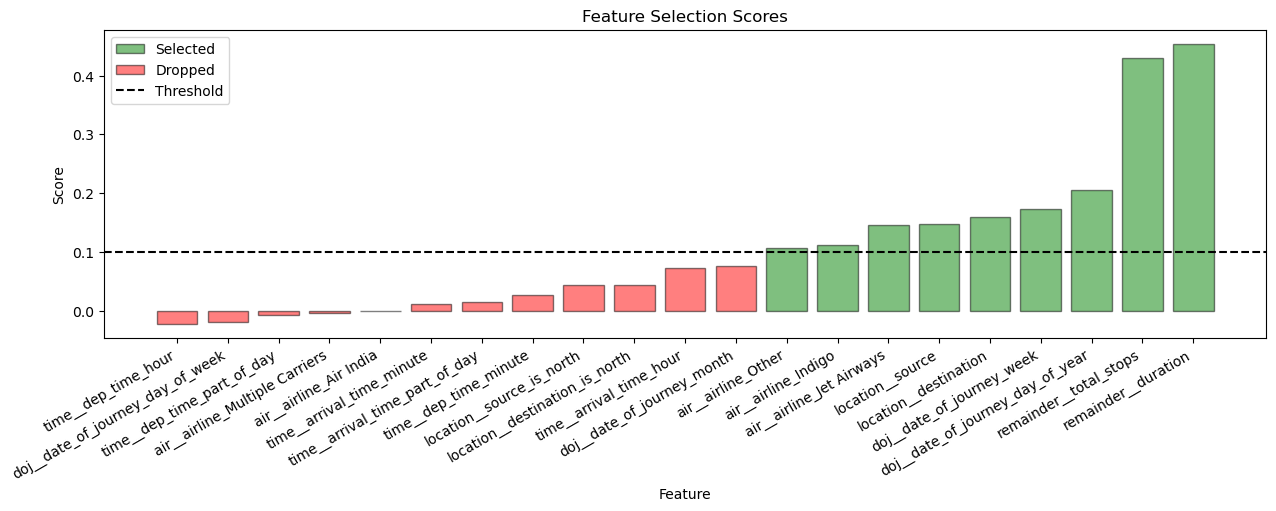

In [106]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()